# Hands-on session 1 - Variational Auto-Encoders
## Generative Modeling Summer School 2024

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


#### Instructions on how to use this notebook:

This notebook is prepared to be hosted on ``Google Colab``. To be able to work on it, you have to create your own copy. In Google Drive: Go to *File* and select *Save a copy in Drive*.

You can also avoid using ``Colab`` entirely, and download the notebook to run it on your own machine. If you choose this, go to *File* and select *Download .ipynb*.

The advantage of using **Colab** is that you can use a GPU. You can complete this assignment with a CPU, but it will take a bit longer. Furthermore, we encourage you to train using the GPU not only for faster training, but also to get experience with this setting. This includes moving models and tensors to the GPU and back. This experience is very valuable because for various models and large datasets (like large CNNs for ImageNet, or Transformer models trained on Wikipedia), training on GPU is the only feasible way.

The default ``Colab`` runtime does not have a GPU. To change this, go to *Runtime - Change runtime type*, and select *GPU* as the hardware accelerator. The GPU that you get changes according to what resources are available at the time, and its memory can go from a 5GB, to around 18GB if you are lucky. If you are curious, you can run the following in a code cell to check:

```sh
!nvidia-smi
```

Note that despite the name, ``Google Colab`` does  not support collaborative work without issues. When two or more people edit the notebook concurrently, only one version will be saved. You can choose to do group programming with one person sharing the screen with the others, or make multiple copies of the notebook to work concurrently.

**Submission:** Please bring your (partial) solution to the hands-on session. Then you can discuss it with intructors and your colleagues.

## Introduction

In this assignment, we are going to implement a Variational Auto-Encoder (VAE). A VAE is a likelihood-based deep generative model that consists of a stochastic encoder (a variational posterior over latent variables), a stochastic decoder, and a marginal distribution over latent variables (a.k.a. a prior). The model was originally proposed in two concurrent papers:
- [Kingma, D. P., & Welling, M. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.](https://arxiv.org/abs/1312.6114)
- [Rezende, Danilo Jimenez, Shakir Mohamed, and Daan Wierstra. "Stochastic backpropagation and approximate inference in deep generative models." International conference on machine learning. PMLR, 2014.](https://proceedings.mlr.press/v32/rezende14.html)

You can read more about VAEs in Chapter 4 of the following book:
- [Tomczak, J.M., "Deep Generative Modeling", Springer, 2022](https://link.springer.com/book/10.1007/978-3-030-93158-2)

In particular, the goals of this assignment are the following:

- Understand how VAEs are formulated
- Implement components of VAEs using PyTorch
- Train and evaluate a model for image data

### Theory behind VAEs

VAEs are latent variable models trained with variational inference. In general, the latent variable models define the following generative process:
\begin{align}
1.\ & \mathbf{z} \sim p_{\lambda}(\mathbf{z}) \\
2.\ & \mathbf{x} \sim p_{\theta}(\mathbf{x}|\mathbf{z})
\end{align}

In plain words, we assume that for observable data $\mathbf{x}$, there are some latent (hidden) factors $\mathbf{z}$. Then, the training objective is the log-likelihood function of the following form:
$$
\log p_{\vartheta}(\mathbf{x})=\log \int p_\theta(\mathbf{x} \mid \mathbf{z}) p_\lambda(\mathbf{z}) \mathrm{d} \mathbf{z} .
$$

The problem here is the intractability of the integral if the dependencies between random variables $\mathbf{x}$ and $\mathbf{z}$ are non-linear and/or the distributions are non-Gaussian.

By introducing variational posteriors $q_{\phi}(\mathbf{z}|\mathbf{x})$, we get the following lower bound (the Evidence Lower Bound, ELBO):
$$
\log p_{\vartheta}(\mathbf{x}) \geq \mathbb{E}_{\mathbf{z} \sim q_\phi(\mathbf{z} \mid \mathbf{x})}\left[\log p_\theta(\mathbf{x} \mid \mathbf{z})\right]-\mathrm{KL}\left(q_\phi(\mathbf{z} \mid \mathbf{x}) \| p_\lambda(\mathbf{z})\right) .
$$

## IMPORTS

In [3]:
# DO NOT REMOVE!
import os

import numpy as np
import matplotlib.pyplot as plt

import torch

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision.datasets import MNIST

In [4]:
# Check if GPU is available and determine the device
if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(f'The available device is {device}')

The available device is cpu


In [5]:
# mount drive: WE NEED IT FOR SAVING IMAGES!
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
# PLEASE CHANGE IT TO YOUR OWN GOOGLE DRIVE!
images_dir = '/content/gdrive/MyDrive/Colab Notebooks/gemss/Results/'

## Auxiliary functions

Let us define some useful log-distributions:

In [7]:
# DO NOT REMOVE
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5


def log_categorical(x, p, num_classes=256, reduction=None, dim=None):
    # Flatten the input x to match the shape of p
    x_flat = x.view(-1)
    # Ensure x_flat values are within the range [0, num_classes-1]
    #x_flat = torch.clamp(x_flat, min=0, max=num_classes-1)

    x_one_hot = F.one_hot(x_flat.long(), num_classes=num_classes).float()

    # Reshape p to match the shape of x_one_hot
    p_flat = p.view(-1, num_classes)

    log_p = x_one_hot * torch.log(p_flat)
    if reduction == 'mean':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_bernoulli(x, p, reduction='sum', dim=None):
    log_p = x * torch.log(p + 1e-8) + (1 - x) * torch.log(1 - p + 1e-8)
    if reduction == 'mean':
        return torch.mean(log_p, dim=dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim=dim)
    else:
        return log_p


def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    log_2pi = torch.log(torch.tensor(2.0 * torch.pi))
    #log_var_ = log_var + 1e-6  # Avoid too small/large log_var values
    log_var_ = log_var.clone()
    for i in range(log_var.size(0)):
      for j in range(log_var.size(1)):
        if log_var[i, j] >1:
          log_var_[i, j] = 1
        elif log_var[i, j] < -1:
          log_var_[i, j] = -1
        else:
         log_var_[i,j] = log_var[i,j] +1e-6
    # Ensure x, mu, and log_var have the correct shape
    if x.shape != mu.shape:
        raise ValueError(f'Shape mismatch: x shape {x.shape} and mu shape {mu.shape}')

    log_p = -0.5 * (log_var_ + ((x - mu) ** 2) / torch.exp(log_var_) + log_2pi)
    if reduction == 'mean':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


## Implementing VAEs

The goal of this assignment is to implement four classes:
- `Encoder`: this class implements the encoder (variational posterior), $q_{\phi}(\mathbf{z}|\mathbf{x})$.
- `Decoder`: this class implements the decoded (the conditional likelihood), $p_{\theta}(\mathbf{x}|\mathbf{z})$.
- `Prior`: this class implements the marginal over latents (the prior), $p_{\lambda}(\mathbf{z})$.
- `VAE`: this class combines all components.

### Encoder
We start with `Encoder`. Please remember that we assume the Gaussian variational posterior with a diagonal covariance matrix.

In [8]:
# YOUR CODE GOES HERE
# NOTE: The class must containt the following functions:
# (i) reparameterization
# (ii) sample
# (iii) log_prob
# Moreover, forward must return the log-probability of the variational posterior for given x, i.e., log q(z|x)

class Encoder(nn.Module):
    def __init__(self, encoder_net):  # ADD APPROPRIATE ATTRIBUTES
        super(Encoder, self).__init__()

        self.encoder = encoder_net
        self.max_log_var = 1 # for numerical stability

    @staticmethod
    def reparameterization(mu, log_var):
        std = torch.exp(0.5 * log_var) + 1e-6
        eps = torch.randn_like(std)
        print(f"Encodeer - shape reparam mu: {mu.shape}, std: {std.shape}, eps: {eps.shape}")
        return mu + eps * std

    def encode(self, x):
        if torch.isnan(x).any():
          raise ValueError('Input contains NaNs')
        mu, log_var = self.encoder(x).chunk(2,dim=1)
        log_var_ = log_var.clone()
        for i in range(log_var.size(0)):
          for j in range(log_var.size(1)):
            if log_var[i, j] > self.max_log_var:
                log_var_[i, j] = self.max_log_var
            elif log_var[i, j] < -self.max_log_var:
                log_var_[i, j] = -self.max_log_var
            else:
              log_var_[i,j] = log_var[i,j] +1e-6
        print(f"Encoder - shape encode mu: {mu.shape}, log_var: {log_var_.shape}") # BxL, BxL
        return mu, log_var_

    def sample(self, x=None, mu_e=None, log_var_e=None):
        if (mu_e is None) and (log_var_e is None):
          mu_e, log_var_e = self.encode(x)
        else:
          if (mu_e is None) or (log_var_e is None):
            raise ValueError('mu and log−var can‘t be None!')

        z = Encoder.reparameterization(mu_e, log_var_e)
        print(f"Encodeer - shape sample mu: {mu_e.shape}, log_var: {log_var_e.shape}, z: {z.shape}")
        print(f"Encoder sample - mu: {mu_e.sum(dim=0)}, log_var: {log_var_e.mean(dim=0)}")
        return z

    def log_prob(self, x=None, mu_e=None, log_var_e=None, z=None):
        if x is not None:
            mu_e, log_var_e = self.encode(x)
            print(f"Encoder log_prob - mu_e: {mu_e}, log_var_e: {log_var_e}")
            if torch.isnan(mu_e).any() or torch.isnan(log_var_e).any():
                raise ValueError('Found nan in mu_e or log_var_e')
            z = self.sample(mu_e=mu_e, log_var_e=log_var_e)
        else:
            if (z is None) or (mu_e is None) or (log_var_e is None):
                raise ValueError('z or mu_e or log_var_e must be given, if x is not provided')
        log_prob_value = log_normal_diag(z, mu_e, log_var_e)
        #print(f"Log probability: {log_prob_value}")
        return log_prob_value

    def forward(self, x, type='log_prob'):
        assert type in ['sample', 'log_prob'], 'forward pass type should either be sample or log_prob'
        if type == 'sample':
          return self.sample(x)
        else:
          return self.log_prob(x)

Please answer the following questions:

#### Question 1

Please explain the reparameterization trick and provide a mathematical formula.

ANSWER: The trick reparametrizes the latent variable $z$ through some random variable $\epsilon$ with known simple distribution $p(\epsilon)$ and a potentially nonlinear transformation $g(x, \epsilon)$:
$$
z_i=g(x_i,\epsilon)
$$
For example, in case of a Gaussian approximate posterior $\mathcal{N}(\mu, \sigma^2)$, we obtain for $\epsilon\sim \mathcal{N}(0,1)$
$$
z=\mu+\sigma\epsilon
$$
In the Gaussian case, the trick allows for backpropagation through the latent space consisting of the parameters $\mu, \sigma$, by fixing them and introducing stochasticity only in $\epsilon$. Additionally, it allows to compute the gradient of the ELBO since the gradients have large variance without reparametrization.


#### Question 2

Please write down mathematically the log-probability of the encoder (variational posterior).

ANSWER:
$$
\log(p(\mathbf{z}|\mathbf{x}))=\prod_{i=1}^n \log(p(z_i|x_i))\\
= \sum_{i=1}^n -0.5\log(2\pi\sigma_i^2)- \sum_{i=1}^n\left(\frac{(z_i-\mu)^2}{\sigma^2}\right)
$$

### Decoder

The decoder is the conditional likelihood, i.e., $p(x|z)$. Please remember that we must decide on the form of the distribution (e.g., Bernoulli, Gaussian, Categorical).

In [9]:
# YOUR CODE GOES HERE
# NOTE: The class must containt the following functions:
# (i) sample
# (ii) log_prob
# Moreover, forward must return the log-probability of the conditional likelihood function for given z, i.e., log p(x|z)
# Additionally, please specify the distribution class you want to use for the decode (i.e. the `distribution` attribute)

class Decoder(nn.Module):
    def __init__(self, decoder_net, distribution='categorical', num_vals=None):
        super(Decoder, self).__init__()

        self.distribution = distribution
        self.decoder_net = decoder_net
        self.num_vals = num_vals

    def decode(self, z):
        assert self.distribution in ['categorical', 'normal', 'bernoulli'], 'Distribution has to be categorical, normal, or bernoulli.'
        h_d = self.decoder_net(z)
        if self.distribution == 'categorical':
            batch_size = h_d.shape[0]
            num_pixels = 28 * 28  # Because we are decoding to 28x28 images
            assert h_d.shape[1] == num_pixels * self.num_vals, "Decoder output size mismatch."
            h_d = h_d.view(batch_size, num_pixels, self.num_vals)
            p = torch.softmax(h_d, dim=2)
            #print(f"Decoder decode - categorical p: {p}")
            return p
        elif self.distribution == 'normal':
            batch_size = h_d.shape[0]
            num_pixels = 28 * 28  # Because we are decoding to 28x28 images
            h_d = h_d.view(batch_size, num_pixels, 2)  # For normal distribution, we expect 2 outputs per pixel (mu and log_var)
            mu, log_var = h_d.chunk(2, dim=2)
            mu = mu.view(batch_size, 1, 28, 28)  # Reshape to match the input shape
            log_var = log_var.view(batch_size, 1, 28, 28)  # Reshape to match the input shape
            #print(f"Decoder decode - m_u: {mu}, log_var: {log_var}")
            return mu, log_var
        else:
            p = torch.sigmoid(h_d)
            #p = p.view(-1, 1, 28, 28)  # Reshape to match the input image dimensions
            #print(f"Decoder decode - bernoulli p: {p.shape}")
            return p

    def sample(self, z):
        params = self.decode(z)
        if self.distribution == 'categorical':
            batch_size = params.shape[0]
            num_pixels = params.shape[1]
            p = params.view(-1, self.num_vals)
            cat_batch_dist = torch.distributions.Categorical(p)
            x = cat_batch_dist.sample().view(batch_size, num_pixels)
        elif self.distribution == 'bernoulli':
            x = torch.bernoulli(params)
        else:
            mu = params[0]
            log_var = params[1]
            std = torch.exp(0.5 * log_var)
            eps = torch.randn_like(mu)
            x = mu + eps * std # Bx1ximage_widthximage_height
        #print(f"Decoder - Sampled x: {x.mean().item()}")
        return x

    def log_prob(self, x, z):
        if self.distribution == 'categorical':
            p = self.decode(z)
            log_p = log_categorical(x, p, num_classes=self.num_vals, reduction='sum', dim=-1).sum(dim=-1) #sums first over categories and then over pixel
        elif self.distribution == 'normal':
            mu, log_var = self.decode(z)
            log_p = log_normal_diag(x, mu, log_var, reduction='sum', dim=1) # sums over pixel
        else:
            p = self.decode(z)
            log_p = log_bernoulli(x, p, reduction='sum', dim=-1) # sums over pixel
        print(f"Log probability decoded x shape: {log_p.shape}")
        return log_p

    def forward(self, z):
        x = self.sample(z)
        log_p = self.log_prob(x, z)
        return log_p


Please answer the following questions:

#### Question 3

Please explain your choice of distribution for image data used in this assignment. Additionally, please write it down mathematically (if you think that presenting it as the log-probability, then please do it).

ANSWER: I expect the pixel values to lie in $\{0,\dots, 255\}^C$ with C=3 being the number of colour chanels (red, green, blue). Thus, the image data lies in $\{0,\dots,255\}^{C\times H\times W}$ with $H$ and $W$ being the height and width of the images. Then, the chosen categorical distribution assigns a probabilities over the whole discrete image space through the density
$$
p(x)=\prod_{c=1}^C\prod_{h=1}^H\prod_{w=1}^Wp_{chw}(x_{chw})
$$
where the pixelwise discrete density is $p_{chw}(x_{chw})=\prod_{j=0}^{255}p_{chw,j}^{[x_{chw}=j]}$. The corresponding log-probability is thus
$$
\log(p(x))=\sum_{c=1}^C\sum_{h=1}^H\sum_{w=1}^W\sum_{j=0}^{255}1[x_{chw}=j]\log p_{chw,j}
$$

#### Question 4

Please explain how one can sample from the distribution chosen by you. Please be specific and formal (i.e., provide mathematical formulae).

To sample an image from the distribution given parameters $p_{chw,j}$, we sample pixelwise from the Multinomial distributions with parameters $n=256, p=(p_{chw,j})_{j=1,\dots,256})$ and combine all values over all chanels, height and width of the image.

To sample in the case of a VAE from the distribution given $\mathbf{z}$ from the latent space, we decode $z$ first to obtain $\mathbf{p}$ and afterwards sample from as above with the parameters given in this $\mathbf{p}$.

### Prior

The prior is the marginal distribution over latent variables, i.e., $p(z)$. It plays a crucial role in the generative process and also in synthesizing images of better quality.

In this assignment, you are asked to implement a prior that is learnable (e.g., parameterized by neural networks). If you decide to implement the standard Gaussian prior only, then please be aware that you will not get any points.

For the learnable prior you can choose the **Mixture of Gaussians**.

In [10]:
# YOUR CODE GOES HERE
# NOTES:
# (i) The function "sample" must be implemented.
# (ii) The function "forward" must return the log-probability, i.e., log p(z)

class Prior(nn.Module):
    def __init__(self, L, components, device='cpu'):
        super(Prior, self).__init__()
        self.L = L
        self.components = components

        self.weights = nn.Parameter(torch.ones(components) / components)
        self.means = nn.Parameter(torch.randn(components, L))
        self.log_vars = nn.Parameter(torch.randn(components, L))

        # Initialize log_vars with small values to avoid numerical instabilities
        #nn.init.constant_(self.log_vars, -1.0)

    def sample(self, batch_size):
        cat_dist = torch.distributions.Categorical(self.weights)
        component_indices = cat_dist.sample((batch_size,))
        samples = []

        for i in range(batch_size):
            idx = component_indices[i]
            mean = self.means[idx]
            log_var = self.log_vars[idx]
            std = torch.exp(0.5 * log_var)
            std_ = std +1e-6  # Ensure std is not too small
            eps = torch.randn_like(mean)
            sample = mean + eps * std_
            samples.append(sample)

        return torch.stack(samples, dim=0)

    def log_prob(self, z):
        log_probs = []
        for i in range(self.components):
            mean = self.means[i]
            log_var = self.log_vars[i]
            #print(f"Prior logprob - mean: {mean.sum(dim=0)}, log_var: {log_var.sum(dim=0)}")
            std = torch.exp(0.5 * log_var)
            std_ = std+1e-6  # Ensure std is not too small
            mvn = torch.distributions.MultivariateNormal(mean, torch.diag(std_**2))
            log_prob = mvn.log_prob(z)
            log_prob = log_prob+torch.log(self.weights[i])
            log_probs.append(log_prob)

        log_probs = torch.stack(log_probs, dim=1)
        log_prob_value = torch.logsumexp(log_probs, dim=1)
        #print(f"Prior log probability: {log_prob_value.sum(dim=0)}")
        return log_prob_value

    def forward(self, z):
        return self.log_prob(z)

In [12]:
class Prior(nn.Module):
    def __init__(self, L):
        super(Prior, self).__init__()
        self.L = L

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
        return log_standard_normal(z)

#### Question 5

**Option 1:  Standard Gaussian**

- Please explain the choice of your prior and write it down mathematically.

**Option 2: Mixture of Gaussians**

Please do the following:
- Please explain the choice of your prior and write it down mathematically.
- Please write down its sampling procedure (if necessary, please add a code snippet).
- Please write down its log-probability (a mathematical formula).

Option 2: The MoG prior is chosen to allow for a trainable prior compared to the Standard Gaussian. The standard Gaussian can lead to holes in the high probability regions of the prior which are poorly covered by the approximate posterior and thus, poorly generated images for samples from these holes. The MoG is given by
$$
p_\lambda(z)=\sum_{k=1}^Kw_k\mathcal{N}(z|\mu_k,\sigma_k^2)
$$
where $\lambda=(\{w_k\},\{\mu_k\}, \{\sigma^2_k\}) are the learnable parameters. The MoG avoids holes between prior and approximate posterior compared to the standard Gaussian.

We can sample from the MoG by sampling first the component $k$ from a Multinomial distribution with probabilities given in $w_k$ and afterwards sampling from the normal distribution of this component, i.e. $\mathcal{N}(\mu_k,\sigma^2_k)$.

The log-probability for L-dimensional Gaussian distributions with diagonal covariance matrix is given by
$$
\log(p(z))=\log(\sum_{k=1}^K w_k pdf(z|\mu_k,\sigma_k^2))\\
pdf(z|\mu_k, \sigma_k^2)=\prod_{d=1}^D\frac{1}{\sqrt{2\pi\sigma_{k,d}^2}}\exp(-\frac{(z_d-\mu_{k,d})^2}{2\sigma_{k,d}^2})
$$

### Complete VAE

The last class is `VAE` tha combines all components. Please remember that this class must implement the **Negative ELBO** in `forward`, as well as `sample` (*hint*: it is a composition of `sample` functions from the prior and the decoder).

In [37]:
# YOUR CODE GOES HERE
# This class combines Encoder, Decoder and Prior.
# NOTES:
# (i) The function "sample" must be implemented.
# (ii) The function "forward" must return the negative ELBO. Please remember to add an argument "reduction", which is either "mean" or "sum".
class VAE(nn.Module):
    def __init__(self, encoder, decoder, prior): # ADD APPROPRIATE ATTRIBUTES IF NECESSARY
        super(VAE, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.prior = prior

        # FILL IN

    def sample(self, x=None, batch_size=64):
        z = self.prior.sample(batch_size)
        x_new = self.decoder.decode(z)
        return x_new

    def forward(self, x, reduction='mean'):
        mu_e,log_var_e = self.encoder.encode(x)
        z = self.encoder.sample(mu_e=mu_e,log_var_e=log_var_e)
        re = self.decoder.log_prob(x,z)

        kl_prior = self.prior.log_prob(z)
        kl_encoder = self.encoder.log_prob(mu_e=mu_e, log_var_e=log_var_e, z=z)
        assert kl_prior.shape == kl_encoder.shape, f"Shape mismatch: {kl_prior.shape} vs {kl_encoder.shape}"
        kl = (kl_prior - kl_encoder).mean(-1)

        elbo = -(re+kl)
        print(f"current elbo {elbo.mean()}")
        if reduction=='mean':
          return elbo.mean()
        else:
          return elbo.sum()


#### Question 6

Please explain your choice of the distribution for the conditional likelihood function, and write down mathematically the log-probability of the decoder.

ANSWER: This is determined by the distribution chosen in the decoder and was given in question 3.

#### Question 7

Please write down mathematically the **Negative ELBO**.

ANSWER:
$$
-ELBO=-\mathbb{E}_{z\sim q_\phi(z|x)}[\log (p_\theta(x|z))]+KL(p_\psi(z)||q_\phi(z|x))\\
=\int \sum_{c=1}^C\sum_{h=1}^H\sum_{w=1}^W\sum_{j=0}^{255}1[x_{chw}=j]\log p_{chw,j}\sum_{k=1}^K w_k \prod_{d=1}^D\frac{1}{\sqrt{2\pi\sigma_{k,d}^2}}\exp(-\frac{(z_d-\mu_{k,d})^2}{2\sigma_{k,d}^2})d\mathbf{z}
- \mathbb{E}_{q_\phi(z|x)}[\log(q_\phi(z|x))-\log(p_\psi(z))]
$$

### Evaluation and training functions

**Please DO NOT remove or modify them.**

In [38]:
# ==========DO NOT REMOVE==========

def evaluation(test_loader, name=None, model_best=None, epoch=None):
    # EVALUATION
    if model_best is None:
        # load best performing model
        model_best = torch.load(name + '.model')

    model_best.eval()
    loss = 0.
    N = 0.
    for indx_batch, (test_batch, _) in enumerate(test_loader):
        test_batch = test_batch.to(device)
        loss_t = model_best.forward(test_batch, reduction='sum')
        loss = loss + loss_t.item()
        N = N + test_batch.shape[0]
    loss = loss / N

    if epoch is None:
        print(f'FINAL LOSS: nll={loss}')
    else:
        print(f'Epoch: {epoch}, val nll={loss}')

    return loss


def samples_real(name, test_loader, shape=(28,28)):
    # real images-------
    num_x = 4
    num_y = 4
    x, _ = next(iter(test_loader))
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name+'_real_images.pdf', bbox_inches='tight')
    plt.close()


def samples_generated(name, data_loader, shape=(28,28), extra_name=''):
    x, _ = next(iter(data_loader))
    x = x.to('cpu').detach().numpy()

    # generations-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.to('cpu').detach().numpy()

    fig, ax = plt.subplots(num_x, num_y)
    for i, ax in enumerate(ax.flatten()):
        plottable_image = np.reshape(x[i], shape)
        ax.imshow(plottable_image, cmap='gray')
        ax.axis('off')

    plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    plt.close()


def plot_curve(name, nll_val):
    plt.plot(np.arange(len(nll_val)), nll_val, linewidth='3')
    plt.xlabel('epochs')
    plt.ylabel('nll')
    plt.savefig(name + '_nll_val_curve.pdf', bbox_inches='tight')
    plt.close()

In [39]:
# ==========DO NOT REMOVE==========

def training(name, max_patience, num_epochs, model, optimizer, training_loader, val_loader, shape=(28,28)):
    nll_val = []
    best_nll = 1000.
    patience = 10

    # Main loop
    for e in range(num_epochs):
        # TRAINING
        model.train()
        for indx_batch, (batch, _) in enumerate(training_loader):
            batch = batch.to(device)
            loss = model.forward(batch, reduction='mean')

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                loss = model.forward(batch, reduction='mean')

            print(f"Epoch {e}, Batch {indx_batch} - Training loss: {loss.item()}")
            scaler.scale(loss).backward()
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            scaler.step(optimizer)
            scaler.update()
            #loss.backward()
            optimizer.step()

        # Validation
        loss_val = evaluation(val_loader, model_best=model, epoch=e)
        nll_val.append(loss_val)  # save for plotting
        scheduler.step(loss)

        if e == 0:
            print('saved!')
            torch.save(model, name + '.model')
            best_nll = loss_val
        else:
            if loss_val < best_nll:
                print('saved!')
                torch.save(model, name + '.model')
                best_nll = loss_val
                patience = 0

                samples_generated(name, val_loader, shape=shape, extra_name="_epoch_" + str(e))
            else:
                patience = patience + 1

        if patience > max_patience:
            break

    nll_val = np.asarray(nll_val)

    return nll_val

### Setup

**NOTE: *Please comment your code! Especially if you introduce any new variables (e.g., hyperparameters).***

In the following cells, we define `transforms` for the dataset. Next, we initialize the data, a directory for results and some fixed hyperparameters.

In [40]:
# PLEASE DEFINE APPROPRIATE TRANFORMS FOR THE DATASET
# (If you don't see any need to do that, then you can skip this cell)
# HINT: Please prepare your data accordingly to your chosen distribution in the decoder
class BernoulliTransform:
    def __call__(self, img):
        # Convert to tensor if not already
        if not isinstance(img, torch.Tensor):
            img = torchvision.transforms.ToTensor()(img)
        # Apply a threshold to binarize the image
        img = (img > 0.5).float()
        # Flatten the image
        return img.view(-1)

# Define the transformation pipeline for training and testing
transforms_train = torchvision.transforms.Compose([
    BernoulliTransform()
])

transforms_test = torchvision.transforms.Compose([
    BernoulliTransform()
])

Please do not modify the code in the next cell.

In [41]:
# ==========DO NOT REMOVE==========
#-dataset
dataset = MNIST('/files/', train=True, download=True,
                      transform=transforms_train
                )

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [50000, 10000], generator=torch.Generator().manual_seed(14))

test_dataset = MNIST('/files/', train=False, download=True,
                      transform=transforms_test
                     )
#-dataloaders
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#-creating a dir for saving results
name = 'vae'
result_dir = images_dir +  name + '/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

#-hyperparams (please do not modify them!)
num_epochs = 100 # max. number of epochs
max_patience = 20 # an early stopping is used, if training doesn't improve for longer than 20 epochs, it is stopped

In [42]:
# Function to get one image and output the scale of values
def get_image_scale(data_loader):
    # Get one batch from the data loader
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Get the image tensor
    image_tensor = images[0]

    # Find the minimum and maximum values
    min_value = torch.min(image_tensor).item()
    max_value = torch.max(image_tensor).item()

    # Get the shape of the image
    image_shape = image_tensor.shape

    return min_value, max_value, image_shape

# Use the function to get the scale and shape of one image
min_value, max_value, image_shape = get_image_scale(train_loader)
print(f"Scale of values in the image tensor: Min={min_value}, Max={max_value}")
print(f"Shape of the image tensor: {image_shape}")

Scale of values in the image tensor: Min=0.0, Max=1.0
Shape of the image tensor: torch.Size([784])


In the next cell, please initialize the model. Please remember about commenting your code!

In [43]:
# BASIC HYPERPARAMETERS
D = 784   # input dimension
L = 16  # number of latents

# model definition
likelihood_type = 'bernoulli'
num_vals = 128

# YOUR CODE COMES HERE:
# FILL IN ANY OTHER HYPERPARAMS YOU WANT TO USE
encoder_net = nn.Sequential(
    nn.Linear(D, 128),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Linear(128, L * 2)
)

decoder_net = nn.Sequential(
    nn.Linear(L, 128),
    nn.BatchNorm1d(128),
    nn.LeakyReLU(negative_slope=0.01),
    nn.Linear(128, D)
)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

encoder_net.apply(weights_init)
decoder_net.apply(weights_init)

encoder = Encoder(encoder_net)
decoder = Decoder(decoder_net, distribution=likelihood_type, num_vals=num_vals)
prior = Prior(L)#, components = 10)

In [44]:
# Function to take one image from the training data loader and encode it
def encode_one_image(data_loader, encoder):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Flatten the image
    images = images.view(images.size(0), -1)

    # Encode the image
    mu, log_var = encoder.encode(images)
    return mu, log_var

# Get one image from the training data loader and encode it
mu, log_var = encode_one_image(train_loader, encoder)
print(f"Encoded mu: {mu.sum(dim=0)}")
print(f"Encoded log_var: {torch.exp(log_var.sum(dim=0))}")

# Function to take one image from the training data loader and pass it through the sample function
def sample_one_image(data_loader, encoder):
    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    # Flatten the image
    images = images.view(images.size(0), -1)

    # Pass the image through the sample function
    z = encoder.sample(x=images)
    return z

# Get one image from the training data loader and pass it through the sample function
z = sample_one_image(train_loader, encoder)
print(f"Sampled z: {z}")

Encoder - shape encode mu: torch.Size([128, 16]), log_var: torch.Size([128, 16])
Encoded mu: tensor([  72.0912,  -92.5759,  -35.5726,   43.4661,  -25.9087,  -56.8831,
          36.4583,  -36.9240,   79.2244,   48.4998,  -42.0737,  -71.3282,
        -114.8711,  -61.9158,  -91.1359,  -10.1994], grad_fn=<SumBackward1>)
Encoded log_var: tensor([1.0784e-10, 3.5608e+10, 1.4991e-08, 9.5088e-01, 3.9873e+00, 2.4372e-07,
               inf, 2.8232e+09, 6.1082e-21, 5.7335e-08, 5.8833e-16, 6.7619e+15,
        6.0667e-06, 3.6472e-25, 1.5389e+03, 2.8256e-40],
       grad_fn=<ExpBackward0>)
Encoder - shape encode mu: torch.Size([128, 16]), log_var: torch.Size([128, 16])
Encodeer - shape reparam mu: torch.Size([128, 16]), std: torch.Size([128, 16]), eps: torch.Size([128, 16])
Encodeer - shape sample mu: torch.Size([128, 16]), log_var: torch.Size([128, 16]), z: torch.Size([128, 16])
Encoder sample - mu: tensor([  69.0373,  -94.7525,  -36.0233,   44.8070,  -23.0412,  -57.8658,
          40.3227,  -37.06

In [45]:
# Initialize the decoders for each distribution type
### Change also last layer of decoder net before checking
decoder_categorical = Decoder(decoder_net, distribution='categorical', num_vals=10)
decoder_normal = Decoder(decoder_net, distribution='normal')
decoder_bernoulli = Decoder(decoder_net, distribution='bernoulli')

# Function to sample from the decoder and return the shape of the sampled images
def sample_from_decoder(decoder, latent_dim):
    # Generate random latent vectors
    z = torch.randn((64, 16))  # Change (1, latent_dim) to match your batch size and latent dimension
    sampled_images = decoder.sample(z)
    return sampled_images.shape

# Sample from each decoder and print the shape of the sampled images
#shape_categorical = sample_from_decoder(decoder_categorical, L)
#shape_normal = sample_from_decoder(decoder_normal, L)
shape_bernoulli = sample_from_decoder(decoder_bernoulli, L)
#print(f"Shape of sampled images from normal decoder: {shape_normal}")
#print(f"Shape of sampled images from categorical decoder: {shape_categorical}")
print(f"Shape of sampled images from bernoulli decoder: {shape_bernoulli}")

Shape of sampled images from bernoulli decoder: torch.Size([64, 784])


In [46]:
# INIT YOUR VAE (PLEASE CALL IT model)
# AN EXAMPLE: model = VAE(encoder, decoder, likelihood_type=likelihood_type, ...)

model = VAE(encoder, decoder, prior)

model.to(device)

VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder_net): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=128, out_features=784, bias=True)
    )
  )
  (prior): Prior()
)

Please initialize the optimizer

In [47]:
# PLEASE DEFINE YOUR OPTIMIZER
lr = 1e-4 # learning rate (PLEASE CHANGE IT AS YOU WISH!)
optimizer = torch.optim.Adamax(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

# Free up unused GPU memory
torch.cuda.empty_cache()

# Initialize mixed precision scaler
scaler = torch.cuda.amp.GradScaler()


/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


#### Question 8

Please explain the choice of the optimizer, and comment on the choice of the hyperparameters (e.g., the learing reate value).

ANSWER: [Please fill in]

### Training and final evaluation

In the following two cells, we run the training and the final evaluation.

In [48]:
# ==========DO NOT REMOVE OR MODIFY==========
# Training procedure
nll_val = training(name=result_dir + name, max_patience=max_patience,
                   num_epochs=num_epochs, model=model, optimizer=optimizer,
                   training_loader=train_loader, val_loader=val_loader,
                   shape=(28,28))

Encoder - shape encode mu: torch.Size([128, 16]), log_var: torch.Size([128, 16])
Encodeer - shape reparam mu: torch.Size([128, 16]), std: torch.Size([128, 16]), eps: torch.Size([128, 16])
Encodeer - shape sample mu: torch.Size([128, 16]), log_var: torch.Size([128, 16]), z: torch.Size([128, 16])
Encoder sample - mu: tensor([  70.1159,  -93.7433,  -35.2272,   42.0663,  -23.3392,  -56.0929,
          40.4631,  -40.5474,   78.8917,   47.3549,  -39.9378,  -70.3841,
        -116.9075,  -62.1597,  -87.8629,   -6.1137], grad_fn=<SumBackward1>), log_var: tensor([-2.0035e-01,  2.1343e-01, -7.9942e-02, -1.9516e-02, -5.6038e-04,
        -7.2885e-02,  8.1129e-01,  1.4743e-01, -3.8203e-01, -1.0644e-01,
        -3.0491e-01,  2.7606e-01, -7.6015e-02, -3.7994e-01,  4.6540e-02,
        -6.9909e-01], grad_fn=<MeanBackward1>)
Log probability decoded x shape: torch.Size([128])
current elbo 645.93505859375


/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
Encoder - shape encode mu: torch.Size([128, 16]), log_var: torch.Size([128, 16])
Encodeer - shape reparam mu: torch.Size([128, 16]), std: torch.Size([128, 16]), eps: torch.Size([128, 16])
Encodeer - shape sample mu: torch.Size([128, 16]), log_var: torch.Size([128, 16]), z: torch.Size([128, 16])
Encoder sample - mu: tensor([ -1.9879,   1.5125,  -1.0437,   4.2025,  -1.5532,  -5.6065,  -3.5680,
          2.6841, -10.9007,   8.9949,   5.9231,   4.1927,  -1.2016,   6.3027,
         -1.6027,   3.6302], grad_fn=<SumBackward1>), log_var: tensor([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1.], grad_fn=<MeanBackward1>)
Log probability decoded x shape: torch.Size([128])
current elbo 114.0560302734375
Encoder - shape encode mu: torch.Size([128, 16]), log_var: torch.Size([128, 16])
Encodeer - shape reparam mu: torch.Size([128, 16]), std: torch.Size([128, 16]), eps: torch.Size([128, 16])
Encod

KeyboardInterrupt: 

Encoder - shape encode mu: torch.Size([128, 16]), log_var: torch.Size([128, 16])
Encodeer - shape reparam mu: torch.Size([128, 16]), std: torch.Size([128, 16]), eps: torch.Size([128, 16])
Encodeer - shape sample mu: torch.Size([128, 16]), log_var: torch.Size([128, 16]), z: torch.Size([128, 16])
Encoder sample - mu: tensor([ 66.9706,  24.5396,  55.5578, -38.4227, -29.1558, -56.7870, -88.4687,
        -10.8828,  34.3244,  18.9265,   5.4100,  10.4308,  54.4164,  60.0438,
         21.2620, -49.0687], grad_fn=<SumBackward1>), log_var: tensor([-0.9889, -0.8435, -0.7896, -0.9756, -0.9514, -0.9828, -0.9864, -0.9611,
        -0.9787, -0.8371, -0.9445, -0.9526, -0.9853, -0.9721, -0.7719, -0.9858],
       grad_fn=<MeanBackward1>)
Log probability decoded x shape: torch.Size([128])
current elbo 166.22140502929688
Encoder - shape encode mu: torch.Size([128, 16]), log_var: torch.Size([128, 16])
Encodeer - shape reparam mu: torch.Size([128, 16]), std: torch.Size([128, 16]), eps: torch.Size([128, 16])


ValueError: cannot reshape array of size 1 into shape (28,28)

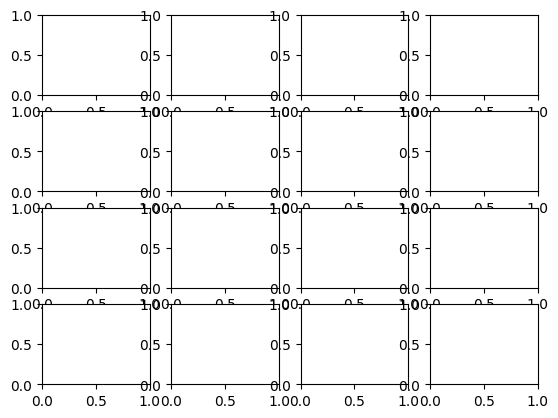

In [29]:
# ==========DO NOT REMOVE OR MODIFY==========
# Final evaluation
test_loss = evaluation(name=result_dir + name, test_loader=test_loader)
f = open(result_dir + name + '_test_loss.txt', "w")
f.write(str(test_loss))
f.close()

samples_real(result_dir + name, test_loader)
samples_generated(result_dir + name, test_loader, extra_name='_FINAL')

plot_curve(result_dir + name, nll_val)

In [36]:
def samples_generated(name, data_loader, shape=(28,28), extra_name=''):
    x, _ = next(iter(data_loader))
    x = x.to('cpu').detach().numpy()

    # generations-------
    model_best = torch.load(name + '.model')
    model_best.eval()

    num_x = 4
    num_y = 4
    x = model_best.sample(num_x * num_y)
    x = x.to('cpu').detach().numpy()
    print(x.shape)
    z=prior.sample(batch_size=9)
    y = decoder.sample(z)
    print(y.shape)
    print(model_best)
    # fig, ax = plt.subplots(num_x, num_y)
    # for i, ax in enumerate(ax.flatten()):
    #     plottable_image = np.reshape(x[i], shape)
    #     ax.imshow(plottable_image, cmap='gray')
    #     ax.axis('off')

    #plt.savefig(name + '_generated_images' + extra_name + '.pdf', bbox_inches='tight')
    #plt.close()
samples_generated(result_dir+name, test_loader)

Log probability decoded x shape: torch.Size([64])
(64,)
torch.Size([9, 784])
VAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=128, out_features=32, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder_net): Sequential(
      (0): Linear(in_features=16, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=128, out_features=784, bias=True)
    )
  )
  (prior): Prior()
)


### Results and discussion

After a successful training of your model, we would like to ask you to present your data and analyze it. Please answer the following questions.

#### Question 9

Please select the real data, and the final generated data and include them in this report. Please comment on the following:
- Do you think the model was trained properly by looking at the generations? Please motivate your answer well.
- What are the potential problems with evaluating a generative model by looking at generated data? How can we evaluate generative models (NOTE: ELBO or NLL do not count as answers)?

ANSWER: [Please fill in]

#### Question 10

Please include the plot of the negative ELBO. Please comment on the following:
- Is the training of your VAE stable or unstable? Why?
- What is the influence of the optimizer on your model? Do the hyperparameter values of the optimizer important and how do they influence the training? Motivate well your answer (e.g., run the script with more than one learning rate and present two plots here).

ANSWER: [Please fill in]